In [2]:
from analyzer import load_trajectory
from analyzer import Geometry, TrajectoryUnit
import pathlib
import pygeos
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon

# Setup geometry & measurement area

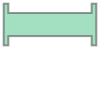

In [7]:
geometry = Polygon([(-10, -2), (-10, 7), (10, 7), (10, -2), (-10, -2)])

geometry_pita = Geometry(geometry)
geometry_pita.add_obstacle(
    Polygon([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)])
)
geometry_pita.add_obstacle(Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

In [ ]:
geometry = Polygon([(-10, -2), (-10, 7), (10, 7), (10, -2), (-10, -2)])

geometry_pita = Geometry(geometry)
geometry_pita.add_obstacle(
    pygeos.polygons([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)])
)
geometry_pita.add_obstacle(
    pygeos.polygons([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)])
)

geometry_shapely = shapely.from_wkt(pygeos.to_wkt(geometry_pita.walkable_area))

ma = pygeos.polygons([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = pygeos.linestrings([(0, 0), (0, 5)])
passing_offset = 1.0

direction = np.array([-1, 0])

traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "demos/uni-directional/traj_UNI_CORR_500_01.txt"
    ),
    default_unit=TrajectoryUnit.METER,
)

Validate that trajectory is completely inside the walkable area.

In [4]:
from analyzer import is_trajectory_valid, get_invalid_trajectory

print(f"Trajectory is valid: {is_trajectory_valid(traj, geometry_pita)}")
get_invalid_trajectory(traj, geometry_pita)

Trajectory is valid: True


,ID,frame,X,Y,Z,points


# Benchmarking

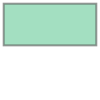

In [23]:
from shapely import Polygon

Polygon(pygeos.get_coordinates(geometry))

## pygeos

In [6]:
%%timeit
traj.data[pygeos.within(traj.data.points, geometry_pita.walkable_area)]

130 ms ± 7.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## shapely

In [7]:
traj_shapely = traj.data.copy(deep=True)

In [13]:
traj_shapely["points"] = shapely.points(traj_shapely["X"], traj_shapely["Y"])

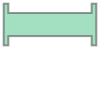

In [20]:
geometry_shapely = shapely.from_wkt(pygeos.to_wkt(geometry_pita.walkable_area))
geometry_shapely

In [21]:
%%timeit
traj_shapely[shapely.within(traj_shapely.points, geometry_shapely)]

119 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plot setup

In [ ]:
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(111, aspect="equal")

# Plot geometry
ax1.plot(*pygeos.to_shapely(geometry_pita.walkable_area).exterior.xy, color="k")

## Plot measurement area
ax1.plot(*pygeos.to_shapely(ma).exterior.xy, color="g")
ax1.fill(*pygeos.to_shapely(ma).exterior.xy, color="g", alpha=0.1)

## Plot measurement lines
ax1.plot(*pygeos.to_shapely(ml).xy, color="b")
ax1.plot(
    *pygeos.to_shapely(pygeos.offset_curve(ml, passing_offset)).xy,
    color="orange",
)

# Plot trajectories
for id, ped in traj.data.groupby("ID"):
    p = ax1.plot(ped["X"], ped["Y"], label=id, alpha=0.1, color="r")
    ax1.scatter(
        ped[ped.frame == ped.frame.max()]["X"],
        ped[ped.frame == ped.frame.max()]["Y"],
        c=p[-1].get_color(),
        marker="x",
    )
plt.show()

# Density

## Classic density

In [ ]:
from analyzer import compute_classic_density

classic_density = compute_classic_density(traj.data, ma)
classic_density

In [ ]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

In [ ]:
from analyzer import compute_voronoi_density

density_voronoi, individual = compute_voronoi_density(
    traj.data, ma, geometry_pita
)

In [ ]:
density_voronoi

In [ ]:
individual

In [ ]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

In [ ]:
density_voronoi_cutoff, individual_cutoff = compute_voronoi_density(
    traj.data, ma, geometry_pita, (1.0, 12)
)

In [ ]:
density_voronoi_cutoff.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi["voronoi density"],
    label="voronoi",
    lw=3,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi cutoff",
    lw=3,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

In [ ]:
frame_start = 1200

for frame in range(frame_start, frame_start + 100, 20):
    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(121, aspect="equal")

    geo_shapely = pygeos.to_shapely(geometry_pita.walkable_area)
    ax1.plot(*geo_shapely.exterior.xy, color="k")
    for hole in geo_shapely.interiors:
        print(hole)
        ax1.plot(*hole.xy, color="k")

    ax1.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame = individual[individual.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])
    for _, row in df_frame.iterrows():
        p = ax1.plot(*pygeos.to_shapely(row[6]).exterior.xy)
        ax1.scatter(row[2], row[3])

        ax1.plot(
            *pygeos.to_shapely(row[6]).exterior.xy, color=p[-1].get_color()
        )
        ax1.fill(
            *pygeos.to_shapely(row[6]).exterior.xy,
            color=p[-1].get_color(),
            alpha=0.1,
        )
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2 = fig.add_subplot(122, aspect="equal")

    ax2.plot(*geo_shapely.exterior.xy, color="k")
    for hole in geo_shapely.interiors:
        ax2.plot(*hole.xy, color="k")
    ax2.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame_cutoff = individual_cutoff[individual_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])
    for _, row in df_frame_cutoff.iterrows():
        p = ax2.plot(*pygeos.to_shapely(row[6]).exterior.xy)
        ax2.scatter(row[2], row[3])

        ax2.plot(
            *pygeos.to_shapely(row[6]).exterior.xy, color=p[-1].get_color()
        )
        ax2.fill(
            *pygeos.to_shapely(row[6]).exterior.xy,
            color=p[-1].get_color(),
            alpha=0.1,
        )

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    fig.tight_layout()
    plt.show()

## Passing density (individual)

In [ ]:
from analyzer import compute_passing_density
from analyzer import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(traj.data, ml, passing_offset)
passing_density = compute_passing_density(classic_density, frames_in_area)
passing_density

# Velocity

In [ ]:
from analyzer import compute_individual_velocity

individual_speed = compute_individual_velocity(traj.data, traj.frame_rate, 5)
individual_speed

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
individual_speed_direction = compute_individual_velocity(
    traj.data, traj.frame_rate, 5, direction
)
individual_speed_direction

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

## Mean speed (all)

In [ ]:
from analyzer import compute_mean_velocity_per_frame

mean_speed, individual_speed = compute_mean_velocity_per_frame(
    traj.data, ma, traj.frame_rate, 10
)
mean_speed

In [ ]:
mean_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
(
    mean_speed_direction,
    individual_speed_direction,
) = compute_mean_velocity_per_frame(
    traj.data, ma, traj.frame_rate, 5, direction
)
mean_speed_direction

## Mean speed (in measurement area)

In [ ]:
from analyzer import get_peds_in_area
from analyzer import compute_mean_velocity_per_frame

peds_in_area = get_peds_in_area(traj.data, ma)
mean_speed_area, individual_speed_area = compute_mean_velocity_per_frame(
    peds_in_area, ma, traj.frame_rate, 5
)

In [ ]:
mean_speed_area.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
(
    mean_speed_area_direction,
    individual_speed_area_direction,
) = compute_mean_velocity_per_frame(
    peds_in_area, ma, traj.frame_rate, 5, direction
)

In [ ]:
individual_speed_area_direction

In [ ]:
mean_speed_area_direction.reset_index().plot.scatter(x="frame", y="speed")

## Voronoi speed

In [ ]:
from analyzer.methods.density_calculator import (
    _compute_individual_voronoi_polygons,
    _compute_intersecting_polygons,
)
from analyzer import (
    compute_individual_velocity,
    compute_voronoi_velocity,
)

In [ ]:
individual_voronoi = _compute_individual_voronoi_polygons(
    traj.data, geometry_pita
)
intersecting_voronoi = _compute_intersecting_polygons(individual_voronoi, ma)

In [ ]:
voronoi_velocity, individual_velocity = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma
)
voronoi_velocity

In [ ]:
voronoi_velocity.reset_index().plot.scatter(x="frame", y="voronoi speed")

In [ ]:
(
    voronoi_velocity_direction,
    individual_velocity_direction,
) = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma, direction
)
voronoi_velocity_direction

## Comparison mean velocity vs voronoi velocity

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(
    voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi"
)
plt.scatter(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.scatter(
    mean_speed_area.reset_index().frame, mean_speed_area, label="classic"
)
plt.scatter(
    mean_speed_area_direction.reset_index().frame,
    mean_speed_area_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

## Passing speed (individual)

In [ ]:
from analyzer import compute_passing_speed
from analyzer import compute_frame_range_in_area

frames_in_area, _ = compute_frame_range_in_area(traj.data, ml, passing_offset)
passing_speed = compute_passing_speed(
    frames_in_area, traj.frame_rate, passing_offset
)
passing_speed

# Flow

## N-t diagram

In [ ]:
from analyzer import compute_n_t

nt, crossing = compute_n_t(traj.data, ml, traj.frame_rate)

In [ ]:
nt.plot(x="Time [s]")

## Flow

In [ ]:
from analyzer import compute_flow

delta_t = 100
flow = compute_flow(nt, crossing, individual_speed, delta_t, traj.frame_rate)
flow

# Profiles

In [ ]:
from analyzer import compute_profiles
from analyzer import compute_voronoi_density
from analyzer import compute_voronoi_velocity

In [ ]:
frames_data = traj.data[traj.data.frame.isin(range(900, 1000))]

voronoi_density_frames, individual_frames = compute_voronoi_density(
    frames_data, ma, geometry_pita, (0.8, 12)
)
voronoi_velocity_frames, individual_velocity_frames = compute_voronoi_velocity(
    traj.data, individual_frames, traj.frame_rate, 5, ma
)

In [ ]:
density_profiles, velocity_profiles = compute_profiles(
    pd.merge(
        individual_frames,
        individual_velocity_frames,
        on=["ID", "frame"],
        how="left",
    ),
    geometry_pita.walkable_area,
    0.2,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bounds = pygeos.bounds(geometry_pita.walkable_area)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="RdBu_r",
    vmin=0,
    vmax=5,
)
fig.colorbar(cm, ax=ax0, shrink=0.3)
ax0.plot(*pygeos.to_shapely(geometry_pita.walkable_area).exterior.xy, color="k")


ax1.set_title("Velocity")
cm = ax1.imshow(
    np.mean(velocity_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    cmap="RdBu",
    vmin=0,
    vmax=1.5,
)
fig.colorbar(cm, ax=ax1, shrink=0.3)

ax1.plot(*pygeos.to_shapely(geometry_pita.walkable_area).exterior.xy, color="k")

fig.tight_layout()